## Per Class Feature Importance (PCFI)

Here we showcase PCFI on the Dermatology dataset. Note that SHAP values could be used instead.

First, we import the our functions and the Dermatology dataset.

In [23]:
%run def_functions.py

proj_path = os.path.dirname(os.getcwd())
#fig_path = proj_path + '/2_docs/LaTeX/Figures'
col_names = np.array([
    'erythema', 'scaling', 'definite borders',
    'itching', 'koebner phenomenon', 'polygonal papules',
    'follicular papules', 'oral mucosal involvement', 'knee and elbow involvement',
    'scalp involvement', 'family history', 'melanin incontinence',
    'eosinophils in the infiltrate', 'PNL infiltrate', 'fibrosis of the papillary dermis',
    'exocytosis', 'acanthosis', 'hyperkeratosis',
    'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges',
    'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
    'focal hypergranulosis', 'disappearance of the granular layer',
    'vacuolisation and damage of basal layer',
    'spongiosis', 'saw-tooth appearance of retes', 'follicular horn plug',
    'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate',
    'band-like infiltrate',
    'Age', 'Class'
])
col_names = np.array([lab.capitalize() for lab in col_names])
feature_names = col_names[:-1]
class_names = np.array(['psoriasis', 'seboreic dermatitis', 'lichen planus',
                        'pityriasis rosea', 'cronic dermatitis', 'pityriasis rubra pilaris'])
class_names = np.array([lab.capitalize() for lab in class_names])
class_tags = np.arange(len(class_names)) + 1
data = pd.read_csv(proj_path+'/0_data/dermatology.data.csv', header=None, names=col_names)
skip_rows = data.Age == '?'
data = data[~skip_rows]
data.Age = np.array(data.Age, dtype=int)

Here we check how imbalanced the dataset is.

Pityriasis rubra pilaris is the rarest class.

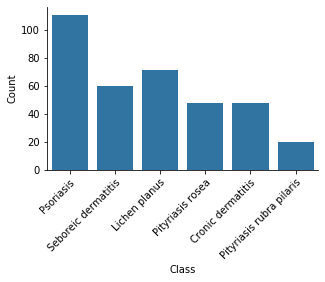

In [24]:
###Class count plot
fig, ax = plt.subplots(figsize=(3.24*1.5, 2*1.5))
sns.countplot(data.loc[:,col_names[-1]].values, color=sns.color_palette()[0], ax=ax, orient='h')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticklabels(class_names, rotation=45, ha='right', rotation_mode='anchor')
sns.despine(fig=fig)
#fig.savefig(fig_path+'/class_counts.pdf', bbox_inches='tight')
plt.show()

Now let's fit a Random Forest Classifier with 100 estimators.

In [25]:
X = np.array(data.loc[:,col_names[:-1]])
y = np.array(data.loc[:,col_names[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)

# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 

# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Mean Absolute Error: 0.02
Model Accuracy: 98.89
(array([1, 2, 3, 4, 5, 6]), array([111,  60,  71,  48,  48,  20]))
(array([1, 2, 3, 4, 5, 6]), array([80, 46, 58, 34, 36, 14]))
(array([1, 2, 3, 4, 5, 6]), array([31, 14, 13, 14, 12,  6]))


From the fitted model, we calculate the PCFI, which results into an importance matrix, and visualise it.
Each row of the matrix provides the importance value of each feature for a given class, and is renormalised to sum up to 1.

From here, we observe the features are more relevant to the prediction of certain classes. For example, Perifollicular parakeratosis and Follicular horn plug are important for the classification of Pityriasis rubra pilaris class only.

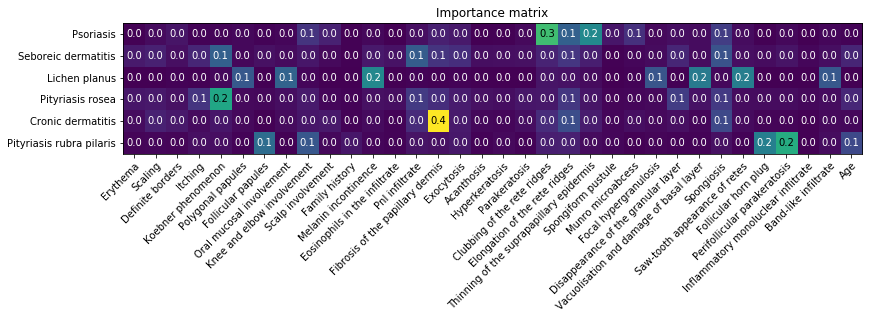

In [26]:
# calculate the importance matrix
imp_mat = calcImportanceMatrix(rf_clf)

# plot the result
fig, ax = plt.subplots(figsize=(len(feature_names)*0.4, len(class_names)*0.4))
im = ax.imshow(imp_mat)

# adding figure annotations
ax.set_xticks(np.arange(imp_mat.shape[1]))
ax.set_yticks(np.arange(imp_mat.shape[0]))
ax.set_xticklabels(feature_names)
ax.set_yticklabels(class_names)

# rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# create text annotations over the heatmap
thresh = imp_mat.max() / 2.
for i in range(len(class_names)):
    for j in range(len(feature_names)):
        text = ax.text(j, i, round(imp_mat[i, j], 1), ha="center", va="center",
                       color="black" if imp_mat[i, j] > thresh else "white")
        
ax.set_title("Importance matrix")
#fig.savefig(fig_path+'/importance_matrix.pdf', bbox_inches='tight')
plt.show()

Calculating the average over the rows of the importance matrix, we obtain a measure for the global importance of the features in the model that is less biased towards more frequent classes.

Here we compare this method to the global importance that is provided by default in the Random Forest class from Scikit-Learn. Indeed, features are weighted differently.

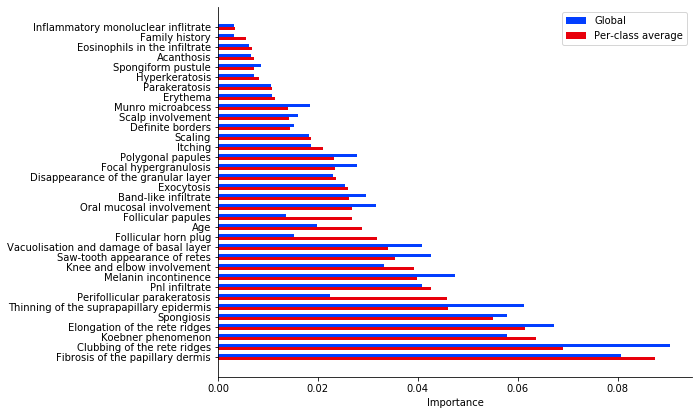

In [27]:
###GLOBAL VS PER-CLASS AVERAGE IMPORTANCE
fig, ax = plt.subplots(figsize=(len(feature_names)/4, len(feature_names)/5))
global_importance = rf_clf.feature_importances_
imp_mat = calcImportanceMatrix(rf_clf)
mean_importance = np.mean(imp_mat, axis=0)
imp_index = np.argsort(mean_importance)
height = 0.3
y_g = np.arange(len(imp_index))[::-1] + (height / 2.)
y_m = np.arange(len(imp_index))[::-1] - (height / 2.)
ax.barh(y=y_g, width=global_importance[imp_index], height=height,
        color=sns.color_palette('bright')[0], label='Global')
ax.barh(y=y_m, width=mean_importance[imp_index], height=height,
        color=sns.color_palette('bright')[3], label='Per-class average')
ax.set_xlabel('Importance')
ax.set_yticks(np.arange(len(imp_index))[::-1])
ax.set_yticklabels(feature_names[imp_index])
ax.legend(loc=1)#bbox_to_anchor=(1.05, 1.05))
sns.despine(fig=fig)
#fig.savefig(fig_path+'/importance_comparison.pdf', bbox_inches='tight')
plt.show()

With seaborn clustermap visualisation, we can tell the classes that are predicted similarly, using a common combination of features.

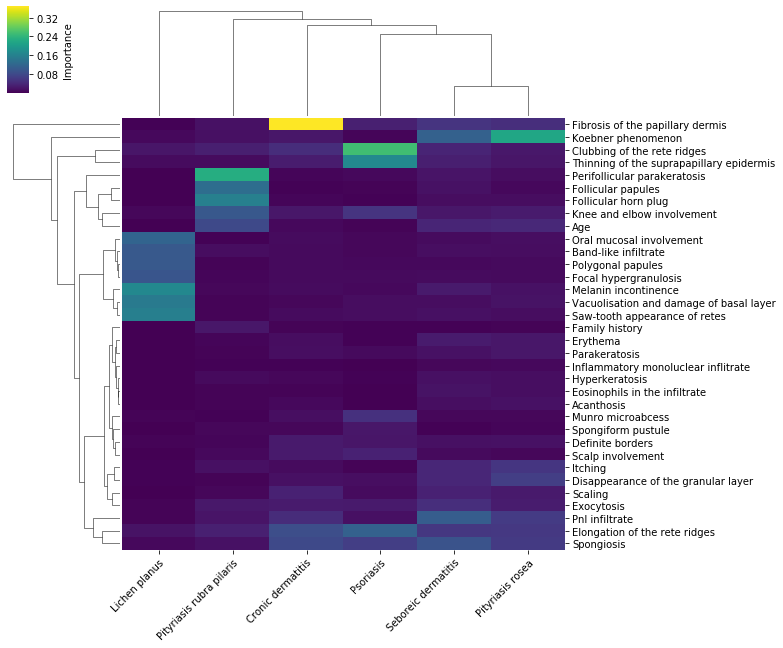

In [28]:
#Heatmap
imp_mat = calcImportanceMatrix(rf_clf)

df_imp_mat = pd.DataFrame(imp_mat.T, columns=class_names, index=feature_names)
cluster_heatmap = sns.clustermap(df_imp_mat, cmap="viridis",
                                 method='average',
                                 cbar_kws={'label':'Importance'},
                                 col_cluster=True, row_cluster=True,
                                 yticklabels=True)
                                 #mask = mask_non_significant)
plt.setp(cluster_heatmap.ax_heatmap.xaxis.get_majorticklabels(),
         rotation=45, ha="right", rotation_mode="anchor")
#cluster_heatmap.savefig(fig_path+'/importance_dendrogram.pdf', bbox_inches='tight')
plt.show()
plt.close()

Here we explore how importance of features is distributed over classes. By setting an importance threshold (0.075 in the example), one can inspect and select those features having higher importance for at least one class.

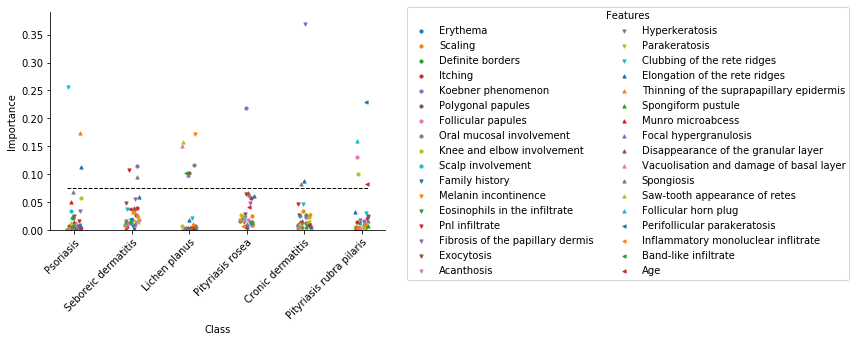

In [29]:
#importance distribution over classes
imp_mat = calcImportanceMatrix(rf_clf)

marker_lst = [
    "o", "v", "^", "<", ">", "1", "2", "3", "4",
    "8", "s", "p", "P", "*", "h", "H", "+", "x",
    "X", "D", "d"
]
color_lst = sns.color_palette(n_colors=10)
color_marker_lst = np.array([(c,m) for m in marker_lst for c in color_lst])

fig, ax = plt.subplots()
for j in np.arange(len(feature_names)):
    ax.scatter(np.arange(len(class_names)) + np.random.uniform(-1,1,size=len(class_names))*.25/2.,
               imp_mat[:,j],
               color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
               s=10, label=feature_names[j])
ax.hlines(y=0.075, xmin=-.25/2., xmax=len(class_names)-1+.25/2., colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Class')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()

The following visualisation combines feature expression (colored by class median) and importance together (dot size). This is particularly useful to inspect whether some highly predictive (i.e. important) features identify a particular class simply by high or low expression.

In the example, high Follicular horn plug and young Age seem to well characterize the class of Pityriasis rubra pilaris.

Data with input dtype int64 was converted to float64 by the scale function.


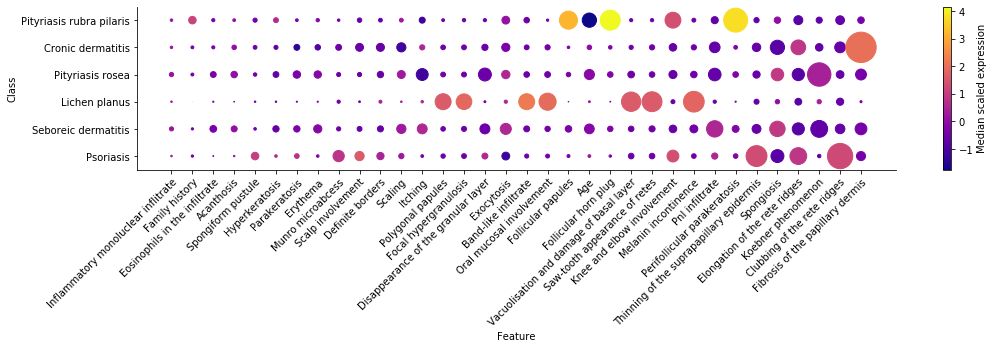

In [30]:
#Feature importance and median expression
imp_mat = calcImportanceMatrix(rf_clf)

mean_imp_per_feat = np.mean(imp_mat, axis=0)
feat_index = np.argsort(mean_imp_per_feat)
feat_reord = feature_names[feat_index]

imp_mat_reord = imp_mat[:,feat_index]

norm_X = scale(X)

x_pos = np.hstack([np.arange(1,len(feat_reord)+1) for k in range(len(class_names))])
y_pos = np.hstack([np.ones(len(feat_reord))*(k+1) for k in range(len(class_names))])
sizes = imp_mat_reord * 2500
medians = np.array([
    np.median(norm_X[y==cl,f_ind]) for cl in class_tags for f_ind in feat_index
])
fig, ax = plt.subplots(figsize=(len(feat_reord)/2, len(class_names)/2))
sc = ax.scatter(x=x_pos, y=y_pos, s=sizes, c=medians, cmap='plasma')

plt.colorbar(sc, label='Median scaled expression')
ax.set_yticks(np.arange(1,len(class_names)+1))
ax.set_yticklabels(class_names)
ax.set_xticks(np.arange(1,len(feat_reord)+1))
ax.set_xticklabels(feat_reord, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Class')
ax.set_xlabel('Feature')

ax.set_ylim(bottom=0.5, top=len(class_names)+0.5)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/importance_expression_heatmap.pdf', bbox_inches='tight')
plt.show()
plt.close()

Print top-5 features ranked by default and PCFI methods (PCFI also on rare class). 

In [31]:
global_importance = rf_clf.feature_importances_
global_index = np.argsort(global_importance)

imp_mat = calcImportanceMatrix(rf_clf)
mean_importance = np.mean(imp_mat, axis=0)
pca_index = np.argsort(mean_importance)

unique_classes, count_classes = np.unique(y, return_counts=True)
rare_class_ind = np.argsort(count_classes)[0]
rare_class = unique_classes[rare_class_ind]
rare_class_index = np.argsort(imp_mat[rare_class_ind])

top5_global_features = feature_names[global_index[-5:]]
top5_pca_features = feature_names[pca_index[-5:]]
top5_rare_features = feature_names[rare_class_index[-5:]]
print(top5_global_features)
print(top5_pca_features)
print(top5_rare_features)

['Spongiosis' 'Thinning of the suprapapillary epidermis'
 'Elongation of the rete ridges' 'Fibrosis of the papillary dermis'
 'Clubbing of the rete ridges']
['Spongiosis' 'Elongation of the rete ridges' 'Koebner phenomenon'
 'Clubbing of the rete ridges' 'Fibrosis of the papillary dermis']
['Age' 'Knee and elbow involvement' 'Follicular papules'
 'Follicular horn plug' 'Perifollicular parakeratosis']


Check confusion matrices on the model refit with same parameters but on selected 5 features.

PCFI returns more accurate predictions than default global importance, and also recapitulated the single rare class when the selection is based on that label only. 

Mean Absolute Error: 0.57
Model Accuracy: 70.0


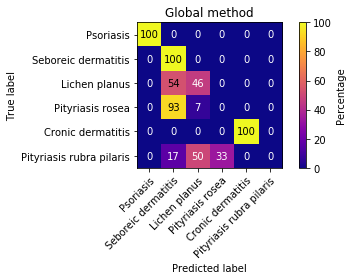

In [32]:
feat_ind = np.array([feat in top5_global_features for feat in feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind], y, random_state=45)
# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

fig, ax = plot_confusion_matrix(y_test, predictions, class_names,
                      title='Global method')
#fig.savefig(fig_path+'/confusion_matrix_default_method.pdf', bbox_inches='tight')
plt.show()

Mean Absolute Error: 0.32
Model Accuracy: 83.33


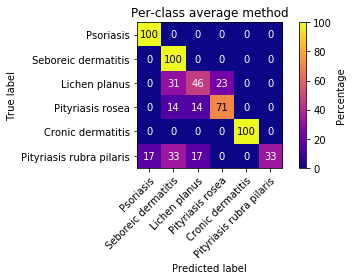

In [33]:
feat_ind = np.array([feat in top5_pca_features for feat in feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind], y, random_state=45)
# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

fig, ax = plot_confusion_matrix(y_test, predictions, class_names,
                      title='Per-class average method')
#fig.savefig(fig_path+'/confusion_matrix_perclass_average.pdf', bbox_inches='tight')
plt.show()

Mean Absolute Error: 0.78
Model Accuracy: 54.44


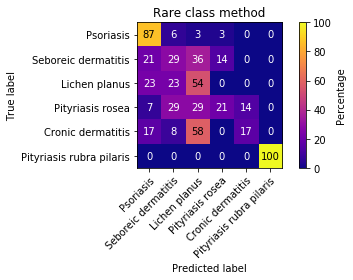

In [34]:
feat_ind = np.array([feat in top5_rare_features for feat in feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind], y, random_state=45)
# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

fig, ax = plot_confusion_matrix(y_test, predictions, class_names,
                      title='Rare class method')
#fig.savefig(fig_path+'/confusion_matrix_rare_class.pdf', bbox_inches='tight')
plt.show()